## Identifying Duplicate Questions

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and make writers to answer multiple versions of the same question. Quora uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.

We are going to build the similar model during this project!

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams

### Punctuation

In [2]:
import string

punctuations = string.punctuation

print(punctuations)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [3]:
# yeah - I'm going to get rid of them all! (except &?)

### Cleaning

- Tokenization
- Stopwords cleaning
- Removing punctuation
- Normalizing
- Stemming

In [4]:
# Import ALL the libraries
import pandas as pd
import numpy as np

# for stopword removal 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# for punctuation removal
import string

# for tokenizing into words
import re
from nltk.tokenize import word_tokenize

# for stemming
nltk.download('punkt')
from nltk.stem import PorterStemmer

# for lematizing
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 

# FEATURE ENGINEERING

# Bag of words count vectorizer
from sklearn.feature_extraction.text import CountVectorizer

# TF-IDF vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

ModuleNotFoundError: No module named 'nltk'

In [35]:
# read fresh data

df = pd.read_csv("data/train.csv")
df = df[0:4000]

#### Clean data

In [36]:
def rename_df(df):
    q = df[['question1', 'question2', 'is_duplicate']]
    q.columns = ['q1', 'q2', 'label']
    return q

def drop_long_short_questions(q):
    q['q1_length'] = q.q1.map(lambda x: len(x))
    q['q2_length'] = q.q2.map(lambda x: len(x))
    
    to_drop = q[(q['q2_length'] < 10) | (q['q1_length'] < 10)].index.tolist()
    q = q.drop(to_drop)

    # drop anything > 500
    to_drop = q[(q['q2_length'] > 500) | (q['q1_length'] > 500)].index.tolist()
    q = q.drop(to_drop)

    # truncate the rest ( most in first part?)
    q = q.drop(columns=['q2_length','q1_length'])
    return q

In [37]:
# strip out bad data before training 

df = df.dropna()
q = rename_df(df)
q = drop_long_short_questions(q)


/var/folders/q4/f3xj1m3j2h3fl1lc7921wysh0000gn/T/ipykernel_10465/1496117259.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q['q1_length'] = q.q1.map(lambda x: len(x))
/var/folders/q4/f3xj1m3j2h3fl1lc7921wysh0000gn/T/ipykernel_10465/1496117259.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q['q2_length'] = q.q2.map(lambda x: len(x))


In [38]:
q.shape

(3999, 3)

In [39]:
# Encompassing function to clean all 
# replace $? contractions?
lemmatizer = WordNetLemmatizer() 
def clean_questions(text):
    text = str(text).strip()  #remove extra spaces at beginning and end
    text = "".join([lemmatizer.lemmatize(word.lower()) for word in text if word not in string.punctuation])   # punctuation
    text = ' '.join( [w for w in text.split() if len(w)>2] )  # remove words 1 letter or less
#     text = [word for word in text if word not in stopwords] # move to tokenizer 
    return text

In [7]:
# # test out function
# text = q.iloc[3]['q1']
# clean_text = clean_questions(text)
# print(clean_text)

In [40]:
def clean_q1_q2(q):
    
    q['cleaned_q1'] = q['q1'].apply(lambda x: clean_questions(x))
    q['cleaned_q2'] = q['q2'].apply(lambda x: clean_questions(x))
    return q

In [41]:
q = clean_q1_q2(q)
q.head()

,q1,q2,label,cleaned_q1,cleaned_q2
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,what the step step guide invest share market i...,what the step step guide invest share market
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,what the story kohinoor kohinoor diamond,what would happen the indian government stole ...
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,how can increase the speed internet connection...,how can internet speed increased hacking throu...
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,why mentally very lonely how can solve,find the remainder when math2324math divided 2423
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,which one dissolve water quikly sugar salt met...,which fish would survive salt water


In [103]:
def find_overlapping_words(q):
    q['q1_words'] = q['cleaned_q1'].apply(lambda x: list(set(x.split())))
    q['q2_words'] = q['cleaned_q2'].apply(lambda x: list(set(x.split())))
#     q['overlap_words'] = q.apply(set(set(q['cleaned_q1'].split()) & set(q['cleaned_q2'].split()))
    return q


In [104]:
q['q2_words'][0]

{'guide', 'invest', 'market', 'share', 'step', 'the', 'what'}

In [113]:
q = find_overlapping_words(q)
q['overlap_words'] = q['q2_words'] + q['q1_words']
q['overlap_words'] = q['overlap_words'].apply(lambda x: set(x))
q.head()
# cols = ['q1_words', 'q2_words']
# q['combined'] = q[cols].apply(lambda row: ''.join(row.values.astype(str)), axis=1)

q['combined'][2]
q['cleaned_q1'][2]

'how can increase the speed internet connection while using vpn'

In [107]:
q.combined[0] # make this back into string!! 

['the',
 'invest',
 'guide',
 'market',
 'what',
 'step',
 'share',
 'the',
 'invest',
 'guide',
 'market',
 'what',
 'step',
 'india',
 'share']

In [114]:
q['questions'] = q['cleaned_q1'] + q['cleaned_q2']

In [116]:
q['questions'][0]

'what the step step guide invest share market indiawhat the step step guide invest share market'

In [10]:
# # Generate duplicate pair word cloud
# word_cloud = WordCloud(background_color='black', max_words=len(dup_str), stopwords=stop_words, width=600, height=400)
# word_cloud.generate(dup_str)

# print('Word cloud for duplicate pairs')
# plt.figure(figsize=(15,8))
# plt.imshow(word_cloud, interpolation='bilinear')
# plt.axis('off')

# plt.show()

### Feature Engineering

- tf-idf
- word2vec
- word count
- number of the same words in both questions
- ....

In [11]:
# # preprocessing ( after strip out bad data above)
# q = rename_df(df)
# q = clean_q1_q2(q)

In [ ]:
df word_count(q):
    pass

In [54]:
def same_words_both_questions(q):
    q['q1_words'] = q.cleaned_q1.map(lambda x: set(x))
    q['q2_words'] = q.cleaned_q2.map(lambda x: set(x))
#     q2_words = set(q.q2)
#     q['same_words'] = set(q1_words & q2_words)
#     q['ratio_same_words_q1'] = len(q1_words & q2_words)/len(q1_words)
#     q['ratio_same_words_q2'] = len(q1_words & q2_words)/len(q2_words)
    return q
    
    

In [55]:
    q['q1_length'] = q.q1.map(lambda x: len(x))
    q['q2_length'] = q.q2.map(lambda x: len(x))

In [56]:
q= same_words_both_questions(q)
q.head()

,q1,q2,label,cleaned_q1,cleaned_q2,q1_words,q2_words,q1_length,q2_length
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,what the step step guide invest share market i...,what the step step guide invest share market,"{r, p, v, g, m, t, k, a, n, , e, s, h, w, d, ...","{r, p, v, g, m, t, k, a, n, , e, s, h, w, d, ...",66,57
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,what the story kohinoor kohinoor diamond,what would happen the indian government stole ...,"{r, y, m, t, k, a, n, , o, e, s, h, w, i, d}","{b, t, k, e, w, p, v, , u, r, c, s, h, l, g, ...",51,88
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,how can increase the speed internet connection...,how can internet speed increased hacking throu...,"{r, p, v, g, t, c, a, n, o, , u, e, s, h, w, ...","{r, p, g, t, k, c, a, n, o, , u, e, s, h, w, ...",73,59
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,why mentally very lonely how can solve,find the remainder when math2324math divided 2423,"{r, v, y, m, t, c, a, n, , o, e, s, h, w, l}","{r, 3, v, m, t, 2, a, n, , f, e, 4, h, w, i, d}",50,65
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,which one dissolve water quikly sugar salt met...,which fish would survive salt water,"{b, t, k, e, w, v, y, , u, r, c, s, h, l, g, ...","{r, v, t, c, a, , f, o, s, e, d, h, w, l, i, u}",76,39


In [30]:
# TfIDF vectorizer
def to_tfidf(q):
    # stopwords = nltk.corpus.stopwords.words('english')
    tfidf_vect = TfidfVectorizer(use_idf=True, max_features = 3000, max_df = 0.8, stop_words=nltk.corpus.stopwords.words('english'))
    # X_tfidf = tfidf_vect.fit_transform(q[['cleaned_q1', 'cleaned_q2']])

    # Make one giant list of all question
    questions = list(list(q['cleaned_q1']) + list(q['cleaned_q2']))

    tfidf_vect.fit(questions)

    q1_tfidf_vect = tfidf_vect.transform(q['cleaned_q1'].values)
    q2_tfidf_vect = tfidf_vect.transform(q['cleaned_q2'].values)

    idf = dict(zip(tfidf_vect.get_feature_names_out(), tfidf_vect.idf_))

    # convert to df
    q1_tfidf_df = pd.DataFrame.sparse.from_spmatrix(q1_tfidf_vect)
    q2_tfidf_df = pd.DataFrame.sparse.from_spmatrix(q2_tfidf_vect)

    # need to df_tfidf_vectorizer_data = pd.DataFrame(tfidf_vectorizer_data.toarray()) to have in dataframe

    tfidf_X = np.hstack((q1_tfidf_df, q2_tfidf_df))
    return(tfidf_X)

In [13]:
tfidf_X = to_tfidf(q)
tfidf_X.shape

/Users/lilakelland/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(3999, 6000)

In [165]:

# # try bag of words - NO BAG OF WORDS

# count_vect = CountVectorizer(stop_words=nltk.corpus.stopwords.words('english'))
# X_count = tfidf_vect.fit_transform(q[['cleaned_q1', 'cleaned_q2']])

In [ ]:
# WORD TO VEC
import gensim
from gensim.models import KeyedVectors
from gensim import models

w2v_model = gensim.models.Word2Vec(X_train,
                                   size=100, # can change this if more complicated - can increase, less, decrease
                                   window=5,
                                   min_count=2) # on

In [ ]:
# pad with zeros - 150 

In [ ]:
# bigrams

### Modeling

Different modeling techniques can be used:

- logistic regression
- XGBoost
- LSTMs
- etc

In [22]:
from sklearn.metrics import roc_auc_score, recall_score, accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
# import xgboost as xgb
# xg_reg = xgb.XGBRegressor(

from sklearn.pipeline import Pipeline


In [26]:
def plot_confusion(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                   display_labels=clf.classes_)
    disp.plot()

    plt.show()

In [16]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_X, q['label'], 
                                                    test_size = 0.2, random_state = 88, stratify=q['label'])


In [ ]:
# #build pipeline
# nlp_pipeline = Pipeline([
#     ('preprocessing', tfidf),
#     ('model', BernoulliNB())
# ], verbose = True)

In [170]:
# %%time
# #fit pipeline
# nlp_pipeline.fit(X_train, y_train)

# train_accuracy = nlp_pipeline.score(X_train,y_train)
# test_accuracy = nlp_pipeline.score(X_test,y_test)

In [171]:
# # predict
# nlp_pipeline.predict(X_test)

#### Baseline Model (Log Regression)

Test set accuracy: 0.6675
Test set recall: 0.5960929811963085
Precision: 0.6675


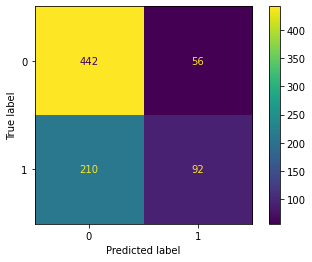

In [27]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')
precision =  precision_score(y_test, y_pred, average='micro')

print(f'Test set accuracy: {acc}')
print(f'Test set recall: {recall}')
print(f'Precision: {precision}')

plot_confusion(y_test, y_pred)

### Niave Bayes

Test set accuracy: 0.64125
Test set recall: 0.5952086491662012
Precision: 0.64125


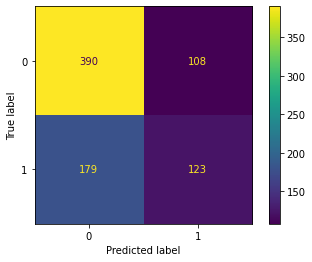

In [28]:
clf = BernoulliNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')
precision =  precision_score(y_test, y_pred, average='micro')

print(f'Test set accuracy: {acc}')
print(f'Test set recall: {recall}')
print(f'Precision: {precision}')

plot_confusion(y_test, y_pred)

### Random Forest

Test set accuracy: 0.6875
Test set recall: 0.6219314343466581
Precision: 0.6875


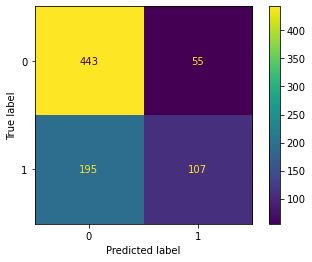

In [29]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')
precision =  precision_score(y_test, y_pred, average='micro')

print(f'Test set accuracy: {acc}')
print(f'Test set recall: {recall}')
print(f'Precision: {precision}')

plot_confusion(y_test, y_pred)

## Deep Learning

In [117]:

from keras.models import Sequential
from keras import layers

input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

ModuleNotFoundError: No module named 'keras'

In [ ]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=100,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

In [ ]:
from keras.backend import clear_session
clear_session()

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

In [ ]:
# Visulalize
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
plot_history(history)

## Word embedding

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentences_train[2])
print(X_train[2])

In [ ]:
from keras.preprocessing.sequence import pad_sequences
# as diff sequences has different lengths, doesn't matter if prepad or post pad

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])
# represents the index in the vocab

In [ ]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)